## Gene Disease Association

#### Libraries

In [2]:
import pickle
import pandas as pd
import networkx as nx
from tabulate import tabulate
import matplotlib.pyplot as plt

#### Variables

In [5]:
# Name of the files to load
Graph_of_PPI_LCC_file_name = "results/PPIGraph/Graph_of_PPI_LCC"
Genes_to_remove_file = "data/GenesToRemove.xlsx"
Genes_to_replace_file = "data/GenesToReplace.xlsx"
Alias_Genes_file = "data/AliasGenes.xlsx"
Seeds_file_name = "data/DISEASES_Summary_GDA_CURATED_C0025202.tsv"

# Name of the file to save
Graph_of_Disease_Interactome_file_name = "results/GDA/Graph_of_Disease_Interactome"
Seed_Genes_in_the_Interactome_file_name = "results/GDA/Seed_Genes_in_the_Interactome"
Deegres_vs_Betwenneess_Centralities_Image_file_name = "results/GDA/Deegrees vs Betwenness Centralities.png"

#### GDA

Features of the Disease Interactome:
Graph with 252 nodes and 847 edges

Features of the LCC from the Disease Interactome:
Graph with 204 nodes and 847 edges

  Disease Name UMLS Disease ID Melanoma MeSH Disease Class Melanoma  \
0     Melanoma                 C0025202                     D008545   

   Number of Associated Genes  Number of Genes Present in the Interactome  \
0                         259                                         252   

   LCC size of the disease interactome  
0                                  204  
  Gene Name  Degree  Betweenness  EigenVector Centrality  Ratio Between-Degree
0      TP53      65     0.164453                0.302398              0.002530
1      RAF1      46     0.118185                0.212720              0.002569
2      CUL3      45     0.087704                0.221758              0.001949
3    HSPA1A      40     0.050598                0.227367              0.001265
4    CTNNB1      38     0.076331                0.212657          

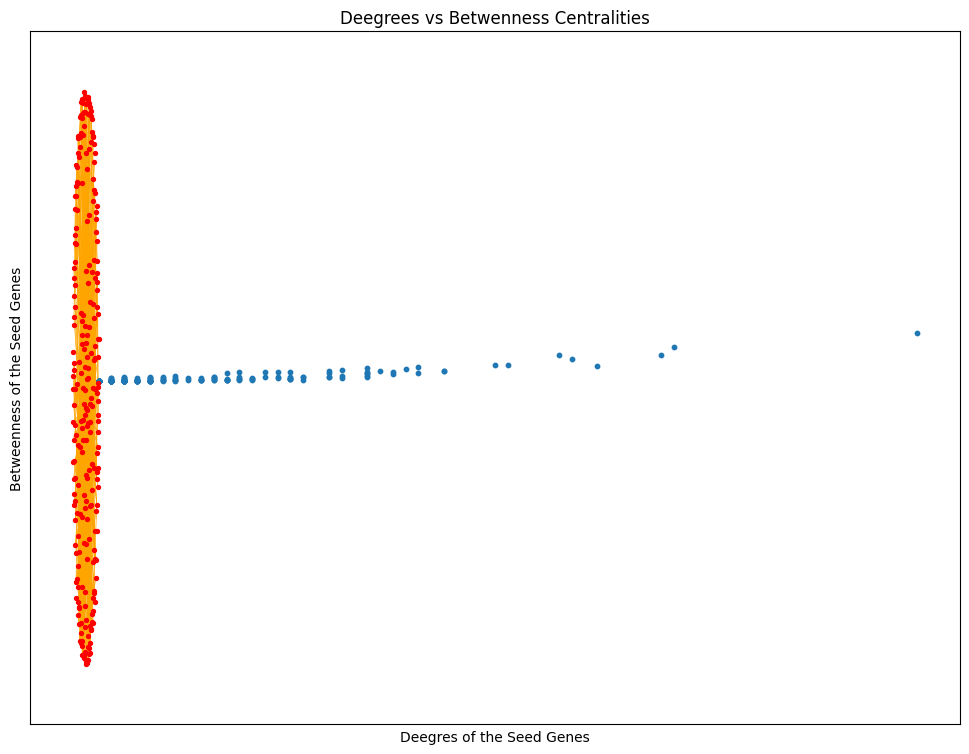

In [8]:
with open(Graph_of_PPI_LCC_file_name, "rb") as file:
    Graph_of_PPI_LCC = pickle.load(file)

Seed_genes_df = pd.read_csv(Seeds_file_name, sep='\t')
GenesToRemove = pd.read_excel(Genes_to_remove_file)
GenesToReplace = pd.read_excel(Genes_to_replace_file)
AliasGenes = pd.read_excel(Alias_Genes_file)

Seed_genes_df_after_HGCN_check = Seed_genes_df[~Seed_genes_df.apply(
    lambda row: row.isin(GenesToRemove["To Remove"].tolist()).any(), axis=1)]
Seed_genes_df_after_HGCN_check = Seed_genes_df_after_HGCN_check.replace(
    dict(zip(GenesToReplace["To Replace"].tolist(),
             GenesToReplace["Approved symbol"].tolist())))

Seed_genes_Symbols = Seed_genes_df_after_HGCN_check["Gene"]
number_of_associated_genes = len(Seed_genes_Symbols)

Graph_of_Disease_Interactome = Graph_of_PPI_LCC.subgraph(Seed_genes_Symbols)
number_of_genes_present_in_the_interactome = len(Graph_of_Disease_Interactome)
print("Features of the Disease Interactome:\n"
      + str(Graph_of_Disease_Interactome) + "\n")
with open(Graph_of_Disease_Interactome_file_name, "wb") as file:
    pickle.dump(Graph_of_Disease_Interactome, file)

# Saving the list of Disease Genes in the Interactome
Seed_Genes_in_the_Interactome_Dictionary = \
    dict(Graph_of_Disease_Interactome.nodes(data=True))
Seed_Genes_in_the_Interactome = \
    pd.Series(Seed_Genes_in_the_Interactome_Dictionary.keys())
with open(Seed_Genes_in_the_Interactome_file_name, "wb") as file:
    pickle.dump(Seed_Genes_in_the_Interactome, file)

Connected_Components_of_Disease_Interactome = \
    nx.connected_components(Graph_of_Disease_Interactome)
largest_cc = max(Connected_Components_of_Disease_Interactome, key=len)

Graph_of_LCC_of_disease_interactome = \
    nx.subgraph(Graph_of_Disease_Interactome, largest_cc).copy()
print("Features of the LCC from the Disease Interactome:\n"
      + str(Graph_of_LCC_of_disease_interactome) + "\n")
LCC_size_of_the_disease_interactome = len(Graph_of_LCC_of_disease_interactome)

Disease_Name = "Melanoma"
UMLS_Disease_ID_Melanoma = "C0025202"
MeSH_Disease_Class_Melanoma = "D008545"

Row_Values = [Disease_Name, UMLS_Disease_ID_Melanoma, MeSH_Disease_Class_Melanoma,
              number_of_associated_genes, number_of_genes_present_in_the_interactome,
              LCC_size_of_the_disease_interactome]
Column_Names = ["Disease Name", "UMLS Disease ID Melanoma", "MeSH Disease Class Melanoma",
                "Number of Associated Genes", "Number of Genes Present in the Interactome",
                "LCC size of the disease interactome"]
Dictionary_of_Gene_Disease_Association_Summary = dict(zip(Column_Names, Row_Values))
#     {column_name: [value] for name, value in zip(Column_Names, Row_Values)}

Summary_of_Gene_Disease_Association = \
    pd.DataFrame(Dictionary_of_Gene_Disease_Association_Summary, index=[0])
print(Summary_of_Gene_Disease_Association)
Latex_Table_of_Summary_of_Gene_Disease_Association = \
    tabulate(Summary_of_Gene_Disease_Association, headers='keys',
             tablefmt='latex', showindex=False)
Length_of_Every_Column_of_Latex_Table = '|'.join(['p{1.5cm}'] * len(Column_Names))
Latex_Table_of_Summary_of_Gene_Disease_Association = \
    Latex_Table_of_Summary_of_Gene_Disease_Association.replace('ll',
                                                               Length_of_Every_Column_of_Latex_Table)

# We choose Spring Layout because allow us to distinguish the connected nodes
# from the unconnected one
# pos = nx.kamada_kawai_layout(Graph_of_Disease_Interactome)
pos = nx.spring_layout(Graph_of_Disease_Interactome, k=1, seed=58)
plt.figure(figsize=(12, 9))
nx.draw_networkx_nodes(Graph_of_Disease_Interactome, pos,
                       node_size=8, node_color="red")
nx.draw_networkx_edges(Graph_of_Disease_Interactome, pos,
                       width=0.5, alpha=1, edge_color="orange")

Degrees_disease_interactome = dict(Graph_of_LCC_of_disease_interactome.degree())
type(Degrees_disease_interactome)
Degrees_disease_interactome_sorted = sorted(Degrees_disease_interactome.items(),
                                            key=lambda x: x[1], reverse=True)
Seed_genes_Sorted_by_degree = [Generic_sorted_Seed[0]
                               for Generic_sorted_Seed
                               in Degrees_disease_interactome_sorted]

Betweenness_disease_interactome = nx.betweenness_centrality(
    Graph_of_LCC_of_disease_interactome)
Eig_Centrality_disease_interactome = nx.eigenvector_centrality(
    Graph_of_LCC_of_disease_interactome)
Collection_of_Centrality_Measures = [(Seed,
                                      Degrees_disease_interactome[Seed],
                                      Betweenness_disease_interactome[Seed],
                                      Eig_Centrality_disease_interactome[Seed],
                                      (Betweenness_disease_interactome[Seed] /
                                       Degrees_disease_interactome[Seed]))
                                     for Seed in Seed_genes_Sorted_by_degree]

Table_Visualization_of_the_Centrality_Measures = pd.DataFrame(
    Collection_of_Centrality_Measures,
    columns=['Gene Name', 'Degree', 'Betweenness', 'EigenVector Centrality',
             'Ratio Between-Degree'])
print(Table_Visualization_of_the_Centrality_Measures.head())

ans = Table_Visualization_of_the_Centrality_Measures.head()

# We can optimize all by writing a function or a class,
# that do all this stuff (if we want)

List_of_Degree_Values = [Centrality_Measure[1]
                         for Centrality_Measure
                         in Collection_of_Centrality_Measures]
List_of_Betweenness_Values = [Centrality_Measure[2]
                              for Centrality_Measure
                              in Collection_of_Centrality_Measures]

plt.scatter(List_of_Degree_Values, List_of_Betweenness_Values,
            s=10)
plt.xlabel('Deegres of the Seed Genes')
plt.ylabel('Betweenness of the Seed Genes')
plt.title("Deegrees vs Betwenness Centralities")
plt.savefig(Deegres_vs_Betwenneess_Centralities_Image_file_name, dpi=300, bbox_inches='tight')
plt.show()
